In [ ]:
!nvidia-smi

Thu Mar 18 08:30:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!pip install gensim --upgrade

Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (4.0.1)


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random


import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, word2id, maxlen, text_field, target_field):
        self.dataset = data[text_field].values
        self.word2id = word2id
        self.maxlen = maxlen
        self.length = data.shape[0]
        self.target = torch.Tensor(data[target_field].values)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        tokens = self.preprocess(self.dataset[idx])
        ids = [self.word2id[token] for token in tokens if token in self.word2id][:self.maxlen]
        ids = torch.nn.functional.pad(torch.LongTensor(ids),
                                     (0, self.maxlen - len(ids)),
                                     mode="constant",
                                     value=0)
        y = self.target[idx]
        return ids, y
    
    @staticmethod
    def preprocess(text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

In [4]:
from gensim.models import FastText

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [5]:
random.seed(42)

In [6]:
quora = pd.read_csv('quora.csv')

MAX_LEN = 150
# словарь
vocab = Counter()

for text in quora.question_text:
    vocab.update(Dataset.preprocess(text))

# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [ ]:
!wget "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"
!unzip wiki-news-300d-1M.vec.zip

In [9]:
!rm wiki-news-300d-1M.vec.zip

In [11]:
import gensim

In [14]:
from gensim.models import KeyedVectors

In [15]:
ftmodel = KeyedVectors.load_word2vec_format("wiki-news-300d-1M.vec")

In [13]:
texts = quora.question_text.apply(Dataset.preprocess).tolist()
fttrained = gensim.models.FastText(sentences=texts, vector_size=300, epochs=3)

In [17]:
pretrained_weights = np.zeros((len(word2id), 300))
trained_weights = np.zeros((len(word2id), 300))

id2word = {}

for word, i in word2id.items():
    id2word[i] = word
    if word == "PAD":
        continue
    try:
        pretrained_weights[i] = ftmodel[word]
    except KeyError:
        pretrained_weights[i] = ftmodel["padding"]
    try:
        trained_weights[i] = fttrained.wv[word]
    except KeyError:
        trained_weights[i] = fttrained.wv["randomword"]

pretrained_weights = torch.tensor(pretrained_weights)
trained_weights = torch.tensor(trained_weights)

In [ ]:
train_dataset, valid_dataset = train_test_split(quora, test_size=0.05)

In [24]:
training_set = Dataset(train_dataset, word2id, MAX_LEN, 'question_text', 'target')
training_generator = torch.utils.data.DataLoader(training_set, batch_size=256)

valid_set = Dataset(valid_dataset, word2id, MAX_LEN, 'question_text', 'target')
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=256)

# Способы суммирования

In [19]:
class Clf_flat(nn.Module):
    def __init__(self,
                 vocab_size:int,
                 embedding_dim:int,
                 embedding_weigths:torch.Tensor,
                 output_dim:int):
        
        super().__init__()          
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(embedding_weigths, freeze=True)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(embedding_dim * MAX_LEN, output_dim)
        self.act = nn.Sigmoid() 
        
    def forward(self, text):
        embedded = self.embedding(text)   
        hidden = self.flatten(embedded)
        dense_outputs = self.fc(hidden)
        out = self.act(dense_outputs)
        return out

class Clf_mean(nn.Module):
    def __init__(self,
                 vocab_size:int,
                 embedding_dim:int,
                 embedding_weigths:torch.Tensor,
                 output_dim:int):
        
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(embedding_weigths, freeze=True)
        self.fc = nn.Linear(embedding_dim, output_dim)
        self.act = nn.Sigmoid()
        
    def forward(self, text):
        embedded = self.embedding(text)
        hidden = torch.mean(embedded, dim=1) # усредняем вектора последовательности
        dense_outputs=self.fc(hidden) # пропускаем через полносвязный слой 
        out = self.act(dense_outputs)
        return out

class Clf_sum(nn.Module):
    def __init__(self,
                 vocab_size:int,
                 embedding_dim:int,
                 embedding_weigths:torch.Tensor,
                 output_dim:int):
        
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(embedding_weigths, freeze=True)
        self.fc = nn.Linear(embedding_dim, output_dim)
        self.act = nn.Sigmoid()
        
    def forward(self, text):
        embedded = self.embedding(text)
        hidden = torch.sum(embedded, dim=1) # усредняем вектора последовательности
        dense_outputs=self.fc(hidden) # пропускаем через полносвязный слой
        out = self.act(dense_outputs)
        return out

In [28]:
model_flat:nn.Module = Clf_flat(len(word2id), 300, pretrained_weights, 1).to(device)
optimizer_flat:torch.optim.Optimizer = torch.optim.Adam(model_flat.parameters())

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model_mean:nn.Module = Clf_mean(len(word2id), 300, pretrained_weights, 1).to(device)
model_sum:nn.Module = Clf_sum(len(word2id), 300, pretrained_weights, 1).to(device)
    
optimizer_mean:torch.optim.Optimizer = torch.optim.Adam(model_mean.parameters())
optimizer_sum:torch.optim.Optimizer = torch.optim.Adam(model_sum.parameters())
loss_fn:nn.modules.loss._Loss = nn.BCELoss().to(device)

def binary_accuracy(preds, y):
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

def train(model:nn.Module,
          iterator:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:nn.modules.loss._Loss,
          print_every:int = 1000):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    for i, (xs, ys) in enumerate(iterator):
        optimizer.zero_grad()
        xs, ys = xs.to(device), ys.to(device)
        
        predictions = model(xs).squeeze()
        loss = loss_fn(predictions.float(), ys.float())
        acc = binary_accuracy(predictions.float(), ys.float())
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        if not (i + 1) % print_every:
            print(f"Loss: {epoch_loss/i}")
            
    return epoch_acc / len(iterator)

def evaluate(model:nn.Module,
             iterator:torch.utils.data.DataLoader,
             loss_fn:nn.modules.loss._Loss):
    epoch_loss = 0
    epoch_accuracy = 0
    
    model.eval()
    
    with torch.no_grad():
        for xs, ys in iterator:
            xs, ys = xs.to(device), ys.to(device)
            predictions = model(xs).squeeze()
            loss = loss_fn(predictions.float(), ys.float())
            acc = binary_accuracy(predictions.float(), ys.float())
            
            epoch_loss += loss.item()
            epoch_accuracy += acc.item()
            
    return epoch_accuracy / len(iterator)

0
Loss: 6.1644967745791925
Loss: 6.2016028778412275
Loss: 6.204064197333983
Loss: 6.200508196500278
1
Loss: 6.183918293293293
Loss: 6.211308779389695
Loss: 6.210533719573191
Loss: 6.205359933733433
2
Loss: 6.183918293293293
Loss: 6.211308779389695
Loss: 6.210533719573191
Loss: 6.205359933733433
3
Loss: 6.183918293293293
Loss: 6.211308779389695
Loss: 6.210533719573191
Loss: 6.205359933733433
4
Loss: 6.183918293293293
Loss: 6.211308779389695
Loss: 6.210533719573191
Loss: 6.205359933733433


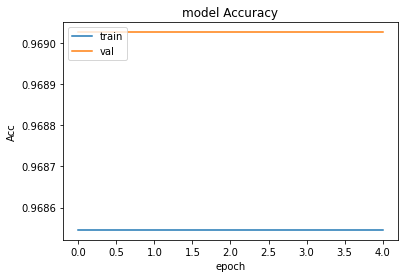

In [29]:
accs = []
accs_eval = []
for i in range(5):
    print(i)
    accs.append(train(model_flat, training_generator, optimizer_flat, loss_fn))
    accs_eval.append(evaluate(model_flat, valid_generator, loss_fn))

plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('model Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

0
Loss: 0.2138447506619884
Loss: 0.19086369314138266
Loss: 0.17654528418911739
Loss: 0.16754973762875708
1
Loss: 0.1314693126376267
Loss: 0.1313739161493034
Loss: 0.1298613709836413
Loss: 0.12896152649370096
2
Loss: 0.12290816060132212
Loss: 0.12352485591364003
Loss: 0.12267761170819387
Loss: 0.12236172117238851
3
Loss: 0.1191685629469735
Loss: 0.11996620393294344
Loss: 0.11931486740688477
Loss: 0.11920280138901186
4
Loss: 0.1171061163050336
Loss: 0.11797022333684536
Loss: 0.11739705795519707
Loss: 0.11737997527996967


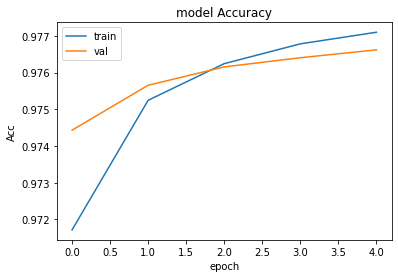

In [27]:
accs = []
accs_eval = []
for i in range(5):
    print(i)
    accs.append(train(model_mean, training_generator, optimizer_mean, loss_fn))
    accs_eval.append(evaluate(model_mean, valid_generator, loss_fn))

plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('model Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

0
Loss: 93.9161818068068
Loss: 93.83871623311656
Loss: 93.82281072857619
Loss: 93.77342027352732
1
Loss: 93.9161818068068
Loss: 93.83871623311656
Loss: 93.82281072857619
Loss: 93.81964631782945
2
Loss: 93.9161818068068
Loss: 93.83871623311656
Loss: 93.82281072857619
Loss: 93.81964631782945
3
Loss: 93.9161818068068
Loss: 93.83871623311656
Loss: 93.82281072857619
Loss: 93.81964631782945
4
Loss: 93.9161818068068
Loss: 93.83871623311656
Loss: 93.82281072857619
Loss: 93.81964631782945


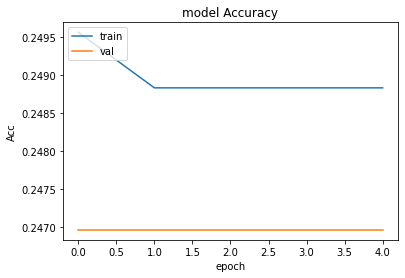

In [30]:
accs = []
accs_eval = []
for i in range(5):
    print(i)
    accs.append(train(model_sum, training_generator, optimizer_sum, loss_fn))
    accs_eval.append(evaluate(model_sum, valid_generator, loss_fn))

plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('model Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 2 FT модели

0
Loss: 0.37658834297795435
Loss: 0.3132213157316993
Loss: 0.27810049670642517
Loss: 0.2547839222833138
1
Loss: 0.1670497890349265
Loss: 0.16619499578229663
Loss: 0.16429894174802856
Loss: 0.16289870735331458
2
Loss: 0.15632357491596086
Loss: 0.15706855979649767
Loss: 0.15629121362815185
Loss: 0.15577001405391255
3
Loss: 0.15290624443982337
Loss: 0.15380972967095946
Loss: 0.15320720208579597
Loss: 0.15287739191987748
4
Loss: 0.1509271163541872
Loss: 0.1518869767708144
Loss: 0.1513604524509038
Loss: 0.1511221239923179


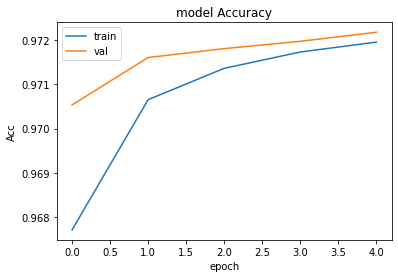

In [57]:


class FT_clf(nn.Module):
    def __init__(self,
                 vocab_size:int,
                 embedding_dim:int,
                 embedding_weights_t:torch.Tensor,
                 embedding_weights_p:torch.Tensor,
                 output_dim:int):
        super().__init__()
        self.embedding_p = nn.Embedding(vocab_size, embedding_dim).from_pretrained(embedding_weights_p, freeze=True)
        self.embedding_t = nn.Embedding(vocab_size, embedding_dim).from_pretrained(embedding_weights_t, freeze=True)
        self.fc = nn.Linear(embedding_dim, output_dim)
        self.act = nn.Sigmoid()
        
    def forward(self, text):
        embedded_p = self.embedding_p(text)
        mean_p = torch.mean(embedded_p, dim=1).unsqueeze(dim=2)
        embedded_t = self.embedding_t(text)
        mean_t = torch.mean(embedded_t, dim=1).unsqueeze(dim=2)
        flat = torch.cat((mean_p, mean_t), dim=2)
        mean = torch.mean(flat, dim =2).float()
        hidden = self.fc(mean)
        out = self.act(hidden)
        return out

FT_model = FT_clf(len(word2id), 300, trained_weights, pretrained_weights, 1).to(device)
optimizer_FT:torch.optim.Optimizer = torch.optim.Adam(FT_model.parameters())

accs = []
accs_eval = []
for i in range(5):
    print(i)
    accs.append(train(FT_model, training_generator, optimizer_FT, loss_fn))
    accs_eval.append(evaluate(FT_model, valid_generator, loss_fn))

plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('model Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()